## 1. 필요 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from mlxtend.frequent_patterns import apriori, association_rules
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as stats
from scipy.stats import gaussian_kde, ks_2samp
from scipy.spatial.distance import jensenshannon
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, SVR, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from itertools import combinations


## 2. 분석에 사용될 함수 정의

In [2]:
# QIM 데이터 분포에 따라 샘플링하는 함수
def shape_based_qim_sampling(qim_data, asrp_data, target_count):
    kde_asrp = gaussian_kde(asrp_data)  
    qim_density = kde_asrp(qim_data)   
    
    # 확률 밀도를 기반으로 샘플링
    sampled_indices = np.random.choice(
        qim_data.index,
        size=target_count,
        replace=False,
        p=qim_density / qim_density.sum()  
    )
    return qim_data.loc[sampled_indices]

In [3]:
# PCA 함수 정의
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca.explained_variance_ratio_


In [4]:
# 고장분류 수행 함수 정의
def classify_with_pca(n_components):

    # PCA 적용 및 데이터 결합
    X_pca_train_reduced, X_pca_test_reduced, explained_var_ratio = apply_pca(X_pca_train_scaled, X_pca_test_scaled, n_components)
    X_train_final = np.hstack([X_fixed_train_scaled, X_pca_train_reduced])
    X_test_final = np.hstack([X_fixed_test_scaled, X_pca_test_reduced])

    # 분류 모델 정의
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "k-NN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
        "MLP": MLPClassifier(random_state=42, max_iter=500)
    }

    # 모델 성능 저장
    results = {}

    for name, model in models.items():
        # 모델 학습 및 예측
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)
        
        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        weighted_avg = report['weighted avg']
        results[name] = {
            "Accuracy": accuracy,
            "Precision": weighted_avg['precision'],
            "Recall": weighted_avg['recall'],
            "F1-Score": weighted_avg['f1-score']
        }

        # 결과 출력
        print(f"Model: {name} with {n_components} PCA components")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted Avg): {weighted_avg['precision']:.4f}")
        print(f"Recall (Weighted Avg): {weighted_avg['recall']:.4f}")
        print(f"F1-Score (Weighted Avg): {weighted_avg['f1-score']:.4f}")
        print("=" * 50)
        
        # 혼동 행렬 시각화
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f"Confusion Matrix: {name} ({n_components} PCA components)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        
        plt.show()
        
    return results, explained_var_ratio

In [5]:
# 검사항목 측정값 예측을 위한 데이터프레임 재구성 함수

def merge_with_selected_columns(qim_final_df, asrp_combined_sorted):
    # '1'부터 '27' 열의 이름을 문자열로 변경
    renamed_columns = {str(i): f"{i}_측정치" for i in range(1, 28)}
    asrp_combined_sorted = asrp_combined_sorted.rename(columns=renamed_columns)
    
    # '1_측정치'부터 '27_측정치' 열과 '운용월' 열 선택
    selected_columns = [f"{i}_측정치" for i in range(1, 28)] + ['운용월']
    asrp_combined_sorted = asrp_combined_sorted[selected_columns]

    total_df = pd.concat([qim_final_df, asrp_combined_sorted], axis=1)

    return total_df  

In [6]:
# POCID 계산 함수(평가지표)
def calculate_pocid(y_true, y_pred):
    correct_direction = np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))
    pocid = np.mean(correct_direction) * 100  # 비율을 퍼센트로 변환
    return pocid

## 3. 필요 데이터 로드

In [7]:
# path에 4개의 엑셀 파일 폴더 경로입력
path = ''

# QIM 데이터
df_QIM = pd.read_csv(path+'/QIM_data.csv', encoding='utf-8')
df_QIM = df_QIM.drop(index=range(0, 4)).reset_index(drop=True)
df_QIM = df_QIM.iloc[:, 2:].reset_index(drop=True)

# 창정비 데이터
df_창정비 = pd.read_csv(path+'/창정비_data.csv', encoding='cp949')
df_창정비 = df_창정비.drop(index=range(0, 4)).reset_index(drop=True)
df_창정비 = df_창정비.iloc[:, 2:].reset_index(drop=True)

# ASRP 데이터
df_ASRP = pd.read_csv(path+'/ASRP_data.csv', encoding='utf-8')
df_ASRP = df_ASRP.drop(index=range(0, 4)).reset_index(drop=True)
df_ASRP = df_ASRP.iloc[:, 2:].reset_index(drop=True)

# 항목별 상하한값
df_lslusl = pd.read_csv(path+'/항목별 상하한.csv')
df_lslusl = df_lslusl.drop(columns=df_lslusl.columns[0], index=df_창정비.index[0:4])

In [8]:
# 데이터 확인
df_QIM

,일련번호,품번,시험일자,1,2,3,4,5,6,7,...,19,20,21,22,23,24,25,26,27,합격여부
0,SG 16 D051 00,81040050,2016.5.26,2.22,2.05,1800,580,550,2400,5400,...,14.98,-15.25,9.43,0.19,20.31,0.82,9.38,0.25,24,합격
1,SG 16 D052 00,81040050,2016.5.26,2.23,2.05,1800,580,550,2400,5500,...,14.94,-14.78,9.84,0.17,20.84,0.83,9.8,0.2,24,합격
2,SG 16 D071K 00,81040050,2016.3.30,2.12,2.05,2300,600,560,3000,6000,...,15.05,-14.98,9.98,0.22,22.12,0.95,10.02,0.29,24,합격
3,SG 16 D072K 00,81040050,2016.3.30,2.17,2.02,2400,600,590,3000,6000,...,14.92,-15.01,10.21,0.2,22.46,1.05,10.24,0.26,24,합격
4,SG 16 D073K 00,81040050,2016.3.30,2.16,2.03,2400,600,580,3000,6000,...,15,-15.34,9.86,0.2,22.05,1.01,9.88,0.26,24,합격
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,SG 15 D023 00,81040050-06,2015.12.3,2.16,2.1,1860,590,580,2400,5500,...,15.03,-14.81,9.66,0.24,20.88,0.81,9.64,0.29,23.72,합격
901,SG 15 D024 00,81040050-06,2015.12.3,2.2,2.06,1840,590,570,2400,5500,...,14.96,-14.78,9.79,0.14,21.07,0.81,9.78,0.19,24,합격
902,SG 15 D025 00,81040050-06,2015.12.3,2.18,2.1,1820,590,560,2400,5500,...,14.92,-14.89,9.45,0.12,20.54,0.62,9.42,0.17,24,합격
903,SG 15 D026 00,81040050-06,2015.12.3,2.18,2.08,1700,590,560,2400,5500,...,14.98,-14.87,9.5,0.19,20.68,0.88,9.48,0.23,24,합격


## 4. 데이터 임의 매칭 및 시각화

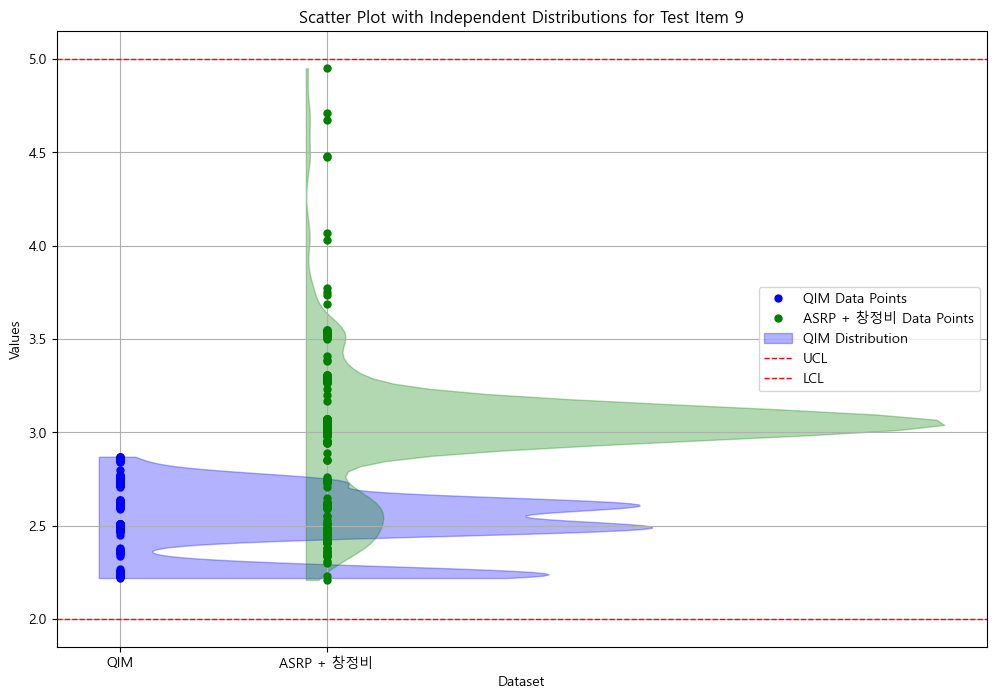

In [9]:
# 데이터셋 병합 (QIM은 유지, 창정비와 ASRP는 하나로 합침)
df_combined = pd.concat([df_QIM, df_창정비, df_ASRP], keys=['QIM', '창정비', 'ASRP']).reset_index(level=0).rename(columns={'level_0': 'Dataset'})

# 'ASRP + 창정비' 새로운 그룹 생성
df_combined['Dataset'] = df_combined['Dataset'].replace(['창정비', 'ASRP'], 'ASRP + 창정비')

# 각 데이터셋 색상을 지정
dataset_colors = {'QIM': 'blue', 'ASRP + 창정비': 'green'}

col_name = '9'
df_combined[col_name] = pd.to_numeric(df_combined[col_name], errors='coerce')

# 상한(UCL)과 하한(LCL) 값 설정
LCL = pd.to_numeric(df_lslusl[col_name].iloc[0], errors='coerce')
UCL = pd.to_numeric(df_lslusl[col_name].iloc[2], errors='coerce') 

plt.figure(figsize=(12, 8))

# LCL 및 UCL 구간 내 데이터 필터링
df_filtered = df_combined[(df_combined[col_name] >= LCL) & (df_combined[col_name] <= UCL)]

x_labels = ['QIM', 'ASRP + 창정비']
for dataset, color in dataset_colors.items():
    filtered_df = df_filtered[df_filtered['Dataset'] == dataset]
    plt.plot([dataset] * len(filtered_df), filtered_df[col_name], 'o', color=color, markersize=5, label=f'{dataset} Data Points')

# 데이터셋별 분포 추가
for idx, (dataset, color) in enumerate(dataset_colors.items()):
    data = df_filtered[df_filtered['Dataset'] == dataset][col_name].dropna()
    if len(data) > 1 and data.std() > 0:  # 데이터 다양성 확인
        # 커널 밀도 추정
        kde = gaussian_kde(data)
        y_vals = np.linspace(data.min(), data.max(), 100)
        x_vals = kde(y_vals)
        # 분포를 각 X축 인덱스 위치에서 오른쪽으로 그림
        plt.fill_betweenx(
            y_vals,
            idx - 0.1,  
            idx - 0.1 + x_vals, 
            color=color,
            alpha=0.3,
            label=f'{dataset} Distribution' if idx == 0 else None, 
        )

# 상한(UCL)과 하한(LCL) 선 표시
plt.axhline(y=UCL, color='red', linestyle='--', linewidth=1, label='UCL')
plt.axhline(y=LCL, color='red', linestyle='--', linewidth=1, label='LCL')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Dataset")
plt.ylabel("Values")
plt.title(f"Scatter Plot with Independent Distributions for Test Item {col_name}")
plt.legend()
plt.grid(True)

plt.show()

ASRP + 창정비 데이터 개수: 489
QIM 데이터 개수: 905
QIM 샘플링 데이터 개수: 489


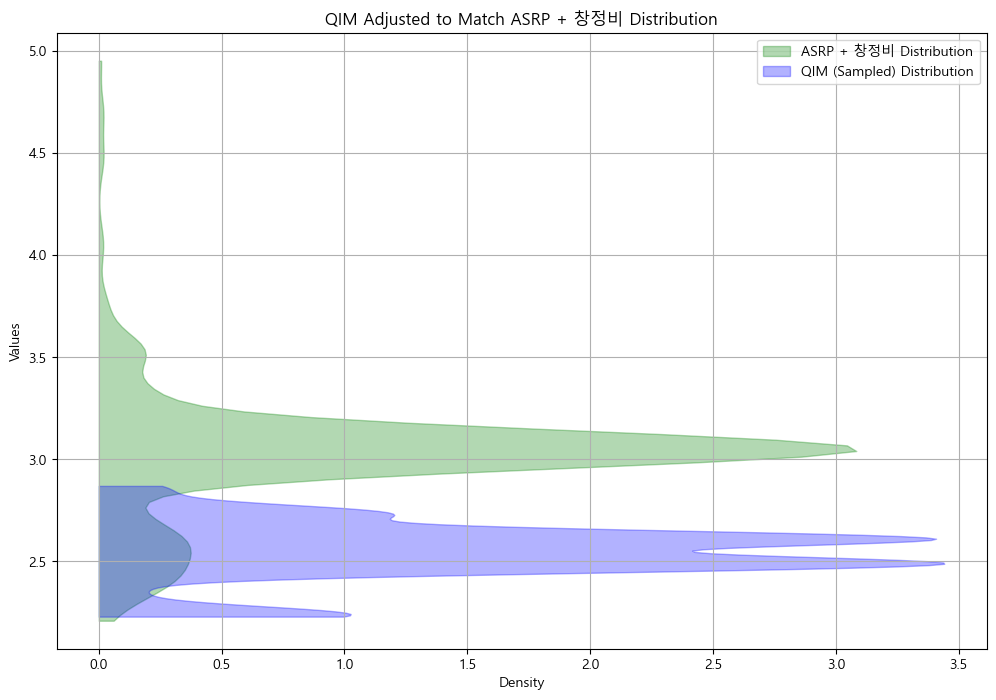

In [10]:
# 데이터 분포 및 개수 확인
combined_data = df_filtered[df_filtered['Dataset'] == 'ASRP + 창정비'][col_name] # ASRP + 창정비
qim_data = df_filtered[df_filtered['Dataset'] == 'QIM'][col_name] # QIM 
print(f"ASRP + 창정비 데이터 개수: {len(combined_data)}")
print(f"QIM 데이터 개수: {len(qim_data)}")

# ASRP + 창정비 분포를 기반으로 KDE 생성
kde_asrp = gaussian_kde(combined_data)

# QIM 데이터에서 ASRP + 창정비 분포의 확률 밀도 계산
qim_density = kde_asrp(qim_data)

# QIM 데이터를 ASRP + 창정비 분포에 맞추어 샘플링 (확률 밀도 기반)
qim_sampled_indices = np.random.choice(
    qim_data.index,
    size=len(combined_data),  # ASRP + 창정비 데이터 크기에 맞추어 샘플링
    replace=False,  
    p=qim_density / qim_density.sum()  
)
qim_sampled = qim_data.loc[qim_sampled_indices]

print(f"QIM 샘플링 데이터 개수: {len(qim_sampled)}")

plt.figure(figsize=(12, 8))

# ASRP + 창정비 분포
y_vals_asrp = np.linspace(combined_data.min(), combined_data.max(), 100)
x_vals_asrp = kde_asrp(y_vals_asrp)
plt.fill_betweenx(y_vals_asrp, np.zeros_like(x_vals_asrp), x_vals_asrp, color='green', alpha=0.3, label='ASRP + 창정비 Distribution')

# QIM (샘플링 후) 분포
kde_qim_sampled = gaussian_kde(qim_sampled)
y_vals_qim = np.linspace(qim_sampled.min(), qim_sampled.max(), 100)
x_vals_qim = kde_qim_sampled(y_vals_qim)

plt.fill_betweenx(y_vals_qim, np.zeros_like(x_vals_qim), x_vals_qim, color='blue', alpha=0.3, label='QIM (Sampled) Distribution')
plt.xlabel("Density")
plt.ylabel("Values")
plt.title("QIM Adjusted to Match ASRP + 창정비 Distribution")
plt.legend()
plt.grid(True)

plt.show()

Original QIM vs ASRP + 창정비:
  - JSD: 0.5527
  - KS Statistic: 0.8344, p-value: 0.0000

Sampled QIM vs ASRP + 창정비:
  - JSD: 0.5573
  - KS Statistic: 0.8344, p-value: 0.0000

Original QIM vs Sampled QIM:
  - JSD: 0.0990
  - KS Statistic: 0.1156, p-value: 0.0004



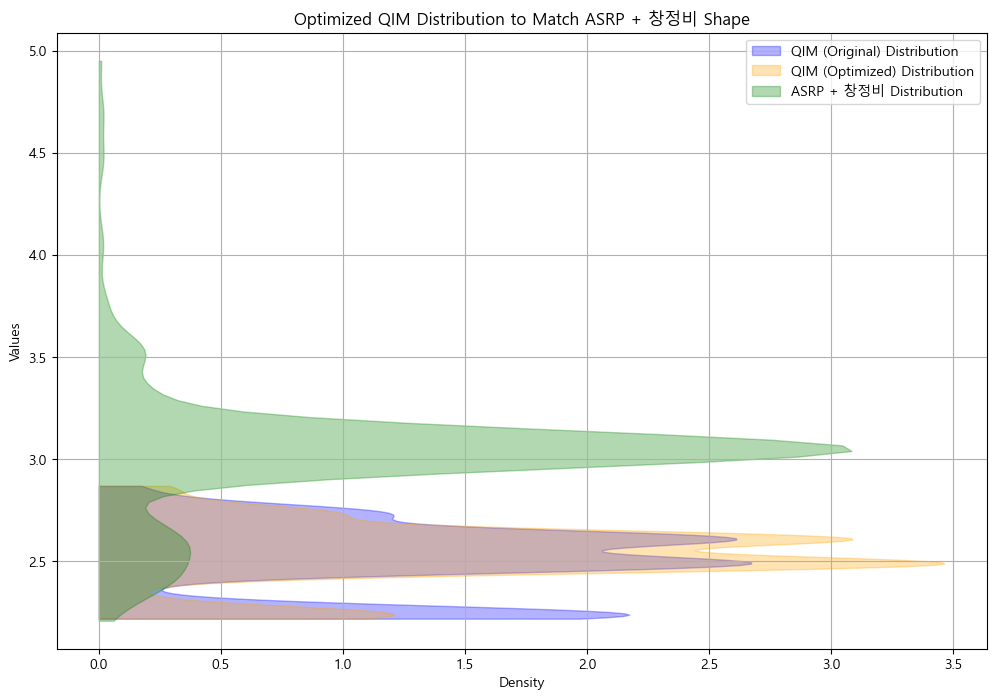

In [11]:
# 분포 조정을 위한 QIM 샘플링
target_count = len(combined_data)
qim_sampled_optimized = shape_based_qim_sampling(qim_data, combined_data, target_count)

# KDE 계산
kde_qim_original = gaussian_kde(qim_data)
y_vals_qim_original = np.linspace(qim_data.min(), qim_data.max(), 100)
x_vals_qim_original = kde_qim_original(y_vals_qim_original)

kde_qim_sampled = gaussian_kde(qim_sampled_optimized)
y_vals_qim_sampled = np.linspace(qim_sampled_optimized.min(), qim_sampled_optimized.max(), 100)
x_vals_qim_sampled = kde_qim_sampled(y_vals_qim_sampled)

# 분포 비교 결과
comparison_results = {
    "Original QIM vs ASRP + 창정비": {
        "JSD": jensenshannon(x_vals_qim_original / x_vals_qim_original.sum(), x_vals_asrp / x_vals_asrp.sum()),
        "KS Test": ks_2samp(qim_data, combined_data)
    },
    "Sampled QIM vs ASRP + 창정비": {
        "JSD": jensenshannon(x_vals_qim_sampled / x_vals_qim_sampled.sum(), x_vals_asrp / x_vals_asrp.sum()),
        "KS Test": ks_2samp(qim_sampled_optimized, combined_data)
    },
    "Original QIM vs Sampled QIM": {
        "JSD": jensenshannon(x_vals_qim_original / x_vals_qim_original.sum(), x_vals_qim_sampled / x_vals_qim_sampled.sum()),
        "KS Test": ks_2samp(qim_data, qim_sampled_optimized)
    }
}

for comparison, results in comparison_results.items():
    print(f"{comparison}:")
    print(f"  - JSD: {results['JSD']:.4f}")
    print(f"  - KS Statistic: {results['KS Test'].statistic:.4f}, p-value: {results['KS Test'].pvalue:.4f}")
    print()

plt.figure(figsize=(12, 8))

plt.fill_betweenx(y_vals_qim_original, np.zeros_like(x_vals_qim_original), x_vals_qim_original, color='blue', alpha=0.3, label='QIM (Original) Distribution')
plt.fill_betweenx(y_vals_qim_sampled, np.zeros_like(x_vals_qim_sampled), x_vals_qim_sampled, color='orange', alpha=0.3, label='QIM (Optimized) Distribution')
plt.fill_betweenx(y_vals_asrp, np.zeros_like(x_vals_asrp), x_vals_asrp, color='green', alpha=0.3, label='ASRP + 창정비 Distribution')

plt.xlabel("Density")
plt.ylabel("Values")
plt.title("Optimized QIM Distribution to Match ASRP + 창정비 Shape")
plt.legend()
plt.grid(True)

plt.show()

In [12]:
# QIM 데이터를 ASRP + 창정비 데이터의 개수에 맞게 샘플링 (확률 밀도 기반)
asrp_count = len(combined_data)  
qim_sampled_indices = np.random.choice(
    qim_data.index,  
    size=asrp_count,  
    replace=False,  
    p=qim_density / qim_density.sum()  # 확률 밀도를 기반으로 샘플링
)
qim_sampled = qim_data.loc[qim_sampled_indices]

# QIM 데이터에서 샘플링된 데이터 필터링
qim_sampled_df = df_filtered[df_filtered['Dataset'] == 'QIM'].loc[qim_sampled_indices].copy()

In [13]:
# ASRP + 창정비 데이터프레임 복사
asrp_combined_df = df_filtered[df_filtered['Dataset'] == 'ASRP + 창정비'].copy()

# 9번 항목 기준 내림차순 정렬
qim_sampled_sorted = qim_sampled_df.sort_values(by=col_name, ascending=False).reset_index(drop=True)
asrp_combined_sorted = asrp_combined_df.sort_values(by=col_name, ascending=False).reset_index(drop=True)

# 데이터프레임 정렬
asrp_combined_sorted = asrp_combined_df.sort_values(by=col_name, ascending=False).reset_index(drop=True)
qim_sampled_sorted = qim_sampled_df.sort_values(by=col_name, ascending=False).reset_index(drop=True)

# 매칭된 '합격여부' 열 추가
qim_sampled_sorted['합격여부'] = asrp_combined_sorted['합격여부'].values

columns_to_keep = ['일련번호'] + [str(i) for i in range(1, 28)] + ['합격여부']
qim_final_df = qim_sampled_sorted[columns_to_keep].copy()

In [14]:
# 합격 및 불합격 데이터 수 확인
value_counts = qim_final_df['합격여부'].value_counts()

print("합격/불합격 개수:")
print(value_counts)

num_pass = value_counts.get('합격', 0)  
num_fail = value_counts.get('불합격', 0)  

print(f"\n합격 개수: {num_pass}")
print(f"불합격 개수: {num_fail}")

합격/불합격 개수:
합격여부
합격     356
불합격    133
Name: count, dtype: int64

합격 개수: 356
불합격 개수: 133


In [15]:
# 만들어진 데이터프레임 확인 
qim_final_df

,일련번호,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,합격여부
0,SG 14 C517 00,2.28,2.16,1800,550,530,2300,5200,540,2.87,...,14.98,-14.87,9.69,0.15,20.7,0.73,9.68,0.17,24,불합격
1,SG 15 D004 00,2.2,2,1800,600,550,2300,5400,560,2.87,...,14.98,-15.33,9.65,0.24,20.46,0.88,9.63,0.3,23.52,불합격
2,SG 15 C927 00,2.12,2,1800,560,550,2400,5500,560,2.87,...,14.96,-14.89,9.89,0.11,20.93,0.59,9.86,0.15,24,불합격
3,SG 14 C520 00,2.26,2.12,1800,550,510,2300,5100,530,2.86,...,14.98,-14.89,9.98,0.11,21.08,0.83,10.02,0.15,24,불합격
4,SG 14 C519 00,2.42,2.22,1800,560,510,2300,5100,530,2.86,...,14.98,-14.89,9.98,0.11,21.08,0.83,10.02,0.15,24,불합격
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,SG 16 D094K 00,2.15,2.06,2000,570,540,3050,5600,560,2.24,...,15.05,-14.87,9.31,0.09,20.98,0.88,9.33,0.15,24,합격
485,SG 16 D076K 00,2.16,2.05,2300,600,570,3000,6000,590,2.23,...,15.01,-15.05,9.94,0.23,22.13,0.99,9.96,0.3,24,불합격
486,SG 16 D075K 00,2.17,2.05,2100,580,550,3000,6100,570,2.23,...,15.03,-14.98,9.96,0.18,22.03,0.85,9.96,0.25,24,불합격
487,SG 17 D364K 00,2.2,2.07,2200,590,550,3100,5800,570,2.23,...,15.01,-14.94,9.82,0.25,21.56,1.28,9.85,0.31,24,불합격


## 5. 분류 모델 훈련 및 평가 (PCA 적용 X)

Model: Logistic Regression
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


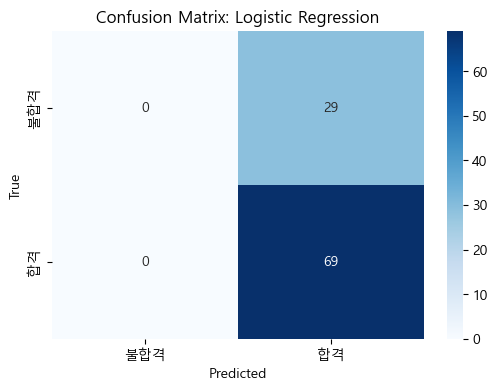

Model: Random Forest
Accuracy: 0.6633
Precision (Weighted Avg): 0.5391
Recall (Weighted Avg): 0.6633
F1-Score (Weighted Avg): 0.5767


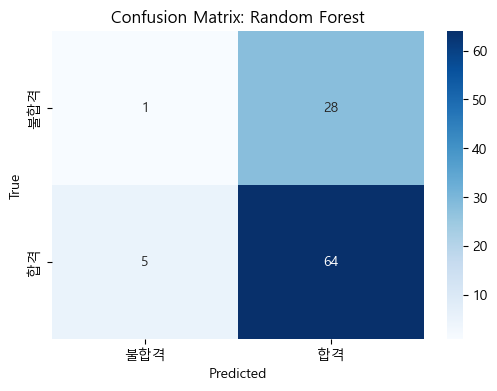

Model: SVM
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


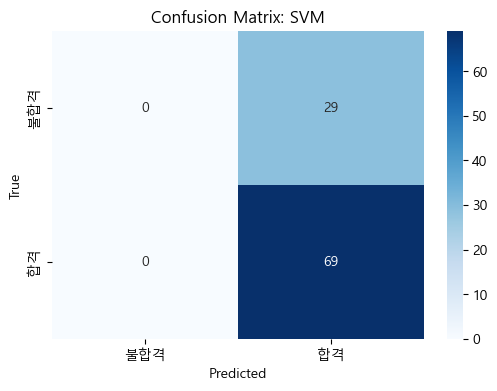

Model: Gradient Boosting
Accuracy: 0.7143
Precision (Weighted Avg): 0.6812
Recall (Weighted Avg): 0.7143
F1-Score (Weighted Avg): 0.6747


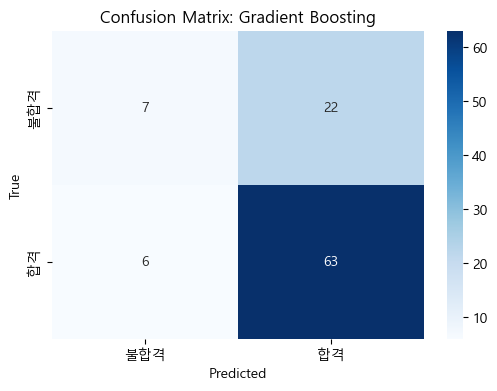

Model: k-NN
Accuracy: 0.6633
Precision (Weighted Avg): 0.5668
Recall (Weighted Avg): 0.6633
F1-Score (Weighted Avg): 0.5899


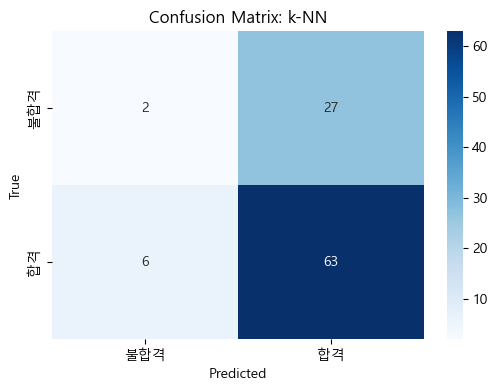

Model: Decision Tree
Accuracy: 0.6122
Precision (Weighted Avg): 0.5783
Recall (Weighted Avg): 0.6122
F1-Score (Weighted Avg): 0.5918


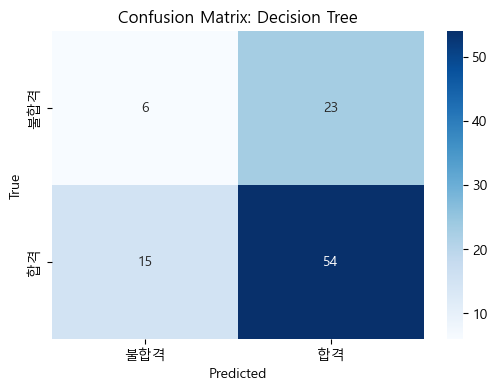

Model: XGBoost
Accuracy: 0.7041
Precision (Weighted Avg): 0.6760
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.6804


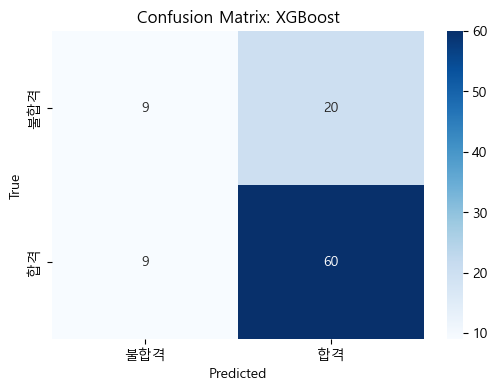

Model: Extra Trees
Accuracy: 0.6531
Precision (Weighted Avg): 0.5562
Recall (Weighted Avg): 0.6531
F1-Score (Weighted Avg): 0.5837


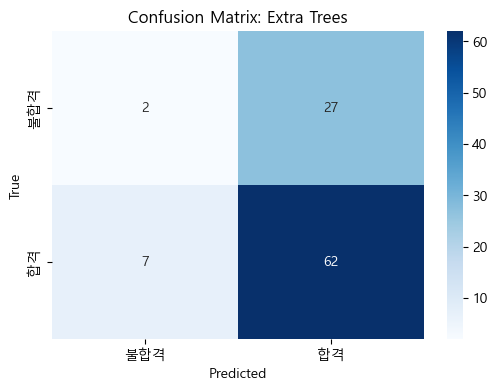

Model: MLP
Accuracy: 0.6939
Precision (Weighted Avg): 0.6501
Recall (Weighted Avg): 0.6939
F1-Score (Weighted Avg): 0.6515


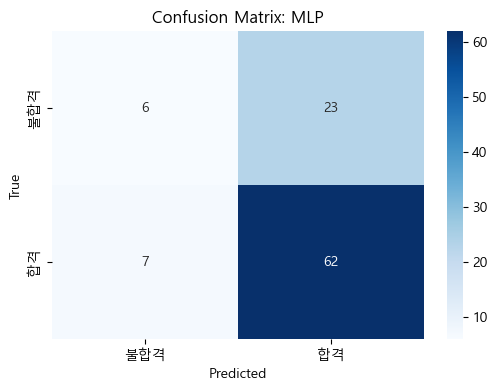

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.704082,0.495731,0.704082,0.581816
Random Forest,0.663265,0.539116,0.663265,0.576676
SVM,0.704082,0.495731,0.704082,0.581816
Gradient Boosting,0.714286,0.681189,0.714286,0.674706
k-NN,0.663265,0.566837,0.663265,0.589943
Decision Tree,0.612245,0.578320,0.612245,0.591848
XGBoost,0.704082,0.676020,0.704082,0.680376
Extra Trees,0.653061,0.556243,0.653061,0.583720
MLP,0.693878,0.650143,0.693878,0.651471


In [16]:
X = qim_final_df[[str(i) for i in range(1, 28)]] # 입력변수(시험항목 1~27)
y = qim_final_df['합격여부'] # 종속변수 : 합격 및 불합격 여부
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# MinMax 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)       

# 고장분류 모델 정의
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "k-NN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "MLP": MLPClassifier(random_state=42, max_iter=500)
}

# 모델 훈련 및 평가
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    weighted_avg = report['weighted avg']
    results[name] = {
        "Accuracy": accuracy,
        "Precision": weighted_avg['precision'],
        "Recall": weighted_avg['recall'],
        "F1-Score": weighted_avg['f1-score']
    }
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted Avg): {weighted_avg['precision']:.4f}")
    print(f"Recall (Weighted Avg): {weighted_avg['recall']:.4f}")
    print(f"F1-Score (Weighted Avg): {weighted_avg['f1-score']:.4f}")
    print("=" * 50)
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

results_df = pd.DataFrame(results).T
results_df

## 6. PCA 적용 고장분류


=== PCA with 1 components ===
Model: Logistic Regression with 1 PCA components
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


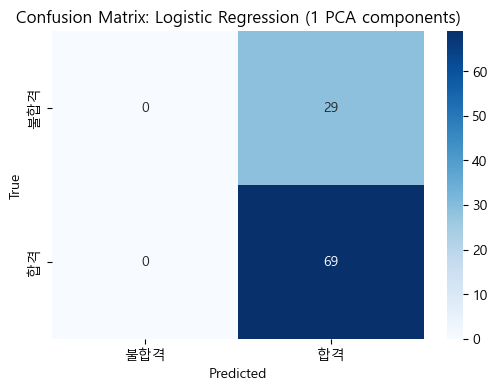

Model: Random Forest with 1 PCA components
Accuracy: 0.6735
Precision (Weighted Avg): 0.5970
Recall (Weighted Avg): 0.6735
F1-Score (Weighted Avg): 0.6082


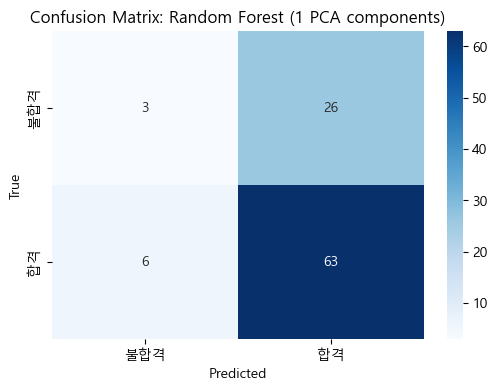

Model: SVM with 1 PCA components
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


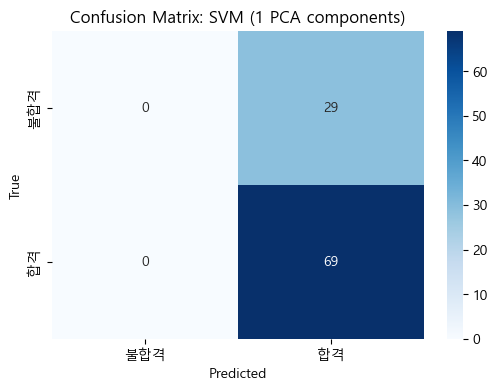

Model: Gradient Boosting with 1 PCA components
Accuracy: 0.6531
Precision (Weighted Avg): 0.5562
Recall (Weighted Avg): 0.6531
F1-Score (Weighted Avg): 0.5837


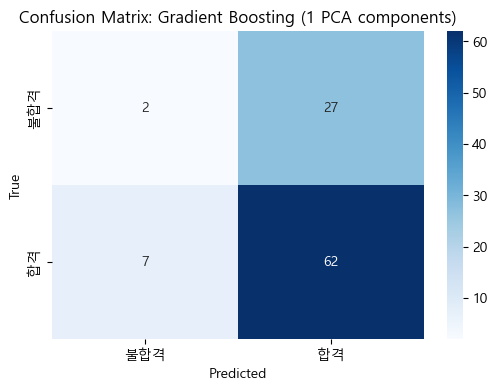

Model: k-NN with 1 PCA components
Accuracy: 0.6633
Precision (Weighted Avg): 0.5980
Recall (Weighted Avg): 0.6633
F1-Score (Weighted Avg): 0.6119


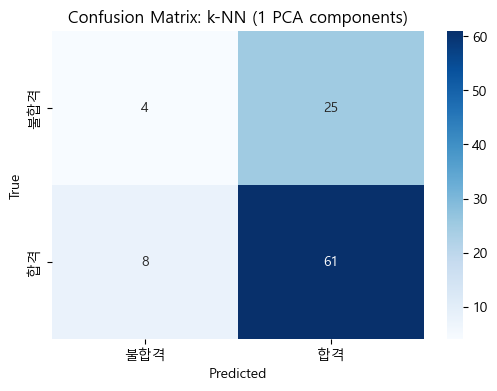

Model: Decision Tree with 1 PCA components
Accuracy: 0.5102
Precision (Weighted Avg): 0.5370
Recall (Weighted Avg): 0.5102
F1-Score (Weighted Avg): 0.5220


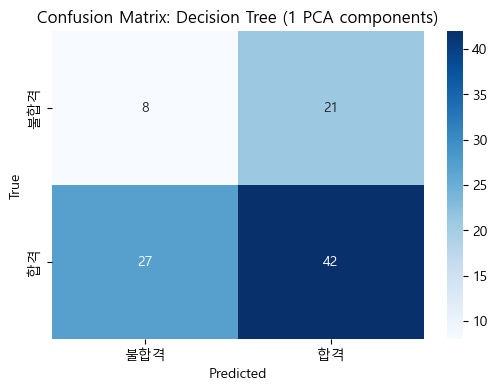

Model: XGBoost with 1 PCA components
Accuracy: 0.6224
Precision (Weighted Avg): 0.5634
Recall (Weighted Avg): 0.6224
F1-Score (Weighted Avg): 0.5842


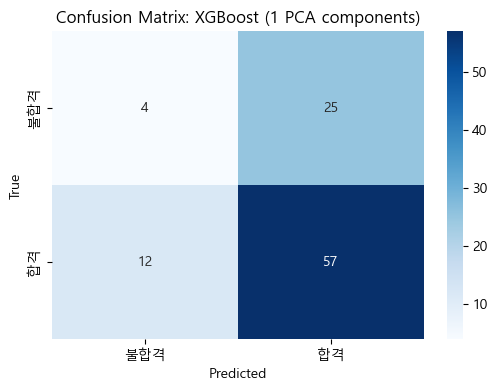

Model: Extra Trees with 1 PCA components
Accuracy: 0.6633
Precision (Weighted Avg): 0.5980
Recall (Weighted Avg): 0.6633
F1-Score (Weighted Avg): 0.6119


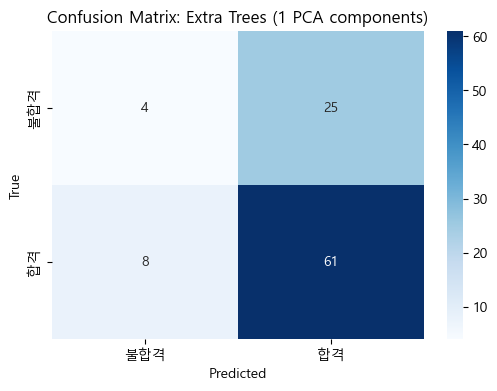

Model: MLP with 1 PCA components
Accuracy: 0.7143
Precision (Weighted Avg): 0.7013
Recall (Weighted Avg): 0.7143
F1-Score (Weighted Avg): 0.6209


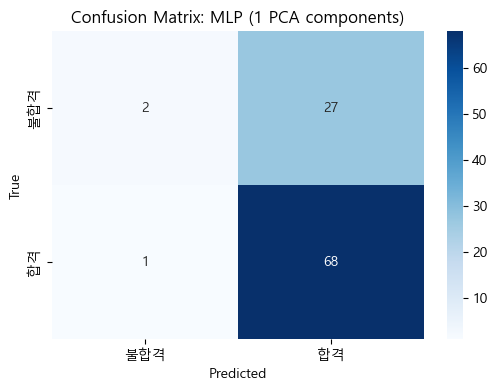


=== PCA with 2 components ===
Model: Logistic Regression with 2 PCA components
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


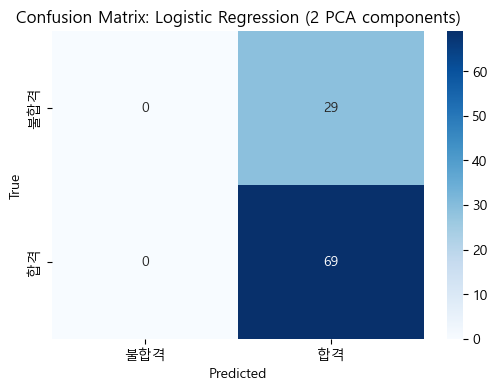

Model: Random Forest with 2 PCA components
Accuracy: 0.6531
Precision (Weighted Avg): 0.5562
Recall (Weighted Avg): 0.6531
F1-Score (Weighted Avg): 0.5837


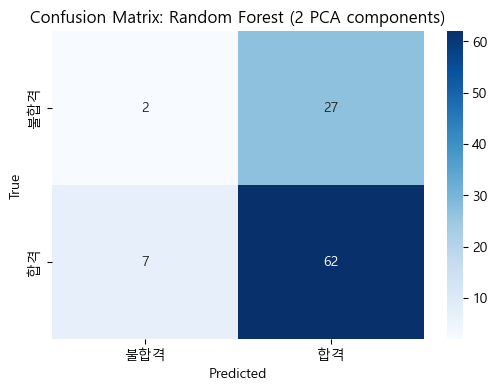

Model: SVM with 2 PCA components
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


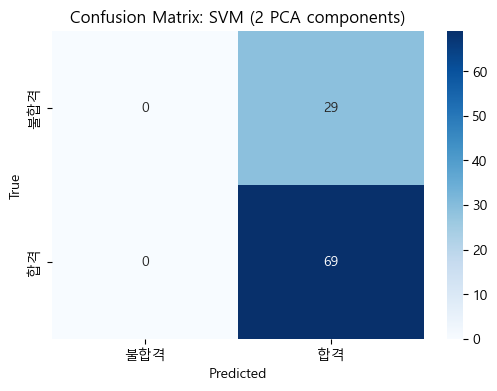

Model: Gradient Boosting with 2 PCA components
Accuracy: 0.6327
Precision (Weighted Avg): 0.5394
Recall (Weighted Avg): 0.6327
F1-Score (Weighted Avg): 0.5712


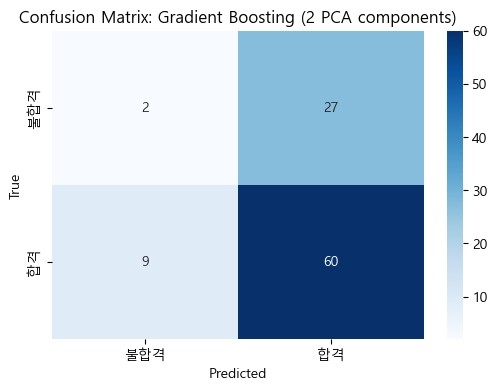

Model: k-NN with 2 PCA components
Accuracy: 0.6633
Precision (Weighted Avg): 0.5980
Recall (Weighted Avg): 0.6633
F1-Score (Weighted Avg): 0.6119


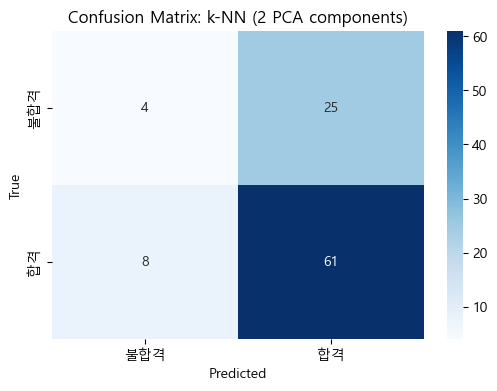

Model: Decision Tree with 2 PCA components
Accuracy: 0.5918
Precision (Weighted Avg): 0.5835
Recall (Weighted Avg): 0.5918
F1-Score (Weighted Avg): 0.5875


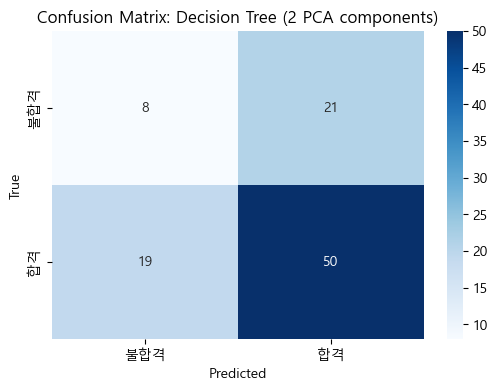

Model: XGBoost with 2 PCA components
Accuracy: 0.6327
Precision (Weighted Avg): 0.5925
Recall (Weighted Avg): 0.6327
F1-Score (Weighted Avg): 0.6068


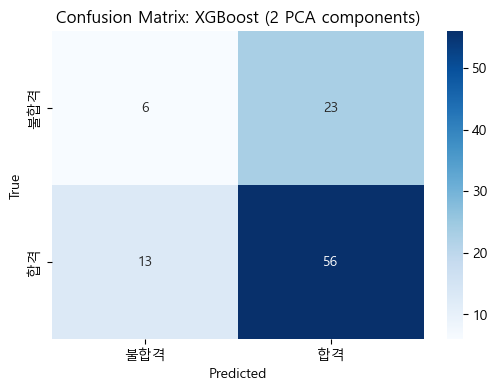

Model: Extra Trees with 2 PCA components
Accuracy: 0.6429
Precision (Weighted Avg): 0.5652
Recall (Weighted Avg): 0.6429
F1-Score (Weighted Avg): 0.5884


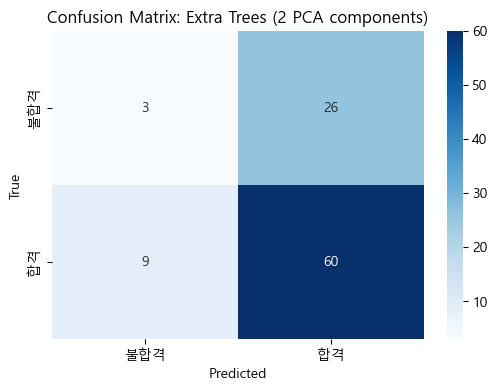

Model: MLP with 2 PCA components
Accuracy: 0.7245
Precision (Weighted Avg): 0.8020
Recall (Weighted Avg): 0.7245
F1-Score (Weighted Avg): 0.6271


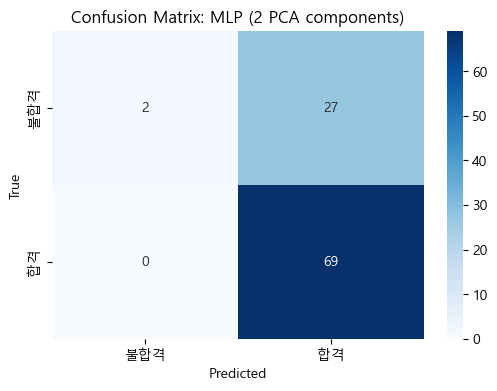


=== PCA with 3 components ===
Model: Logistic Regression with 3 PCA components
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


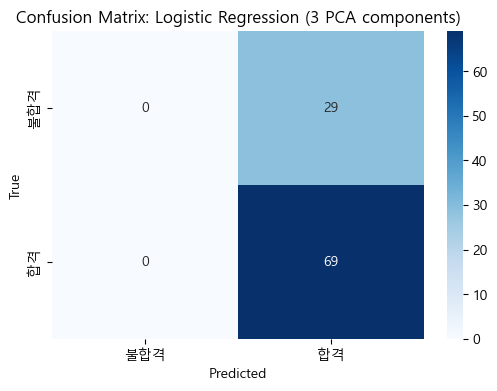

Model: Random Forest with 3 PCA components
Accuracy: 0.6429
Precision (Weighted Avg): 0.5220
Recall (Weighted Avg): 0.6429
F1-Score (Weighted Avg): 0.5651


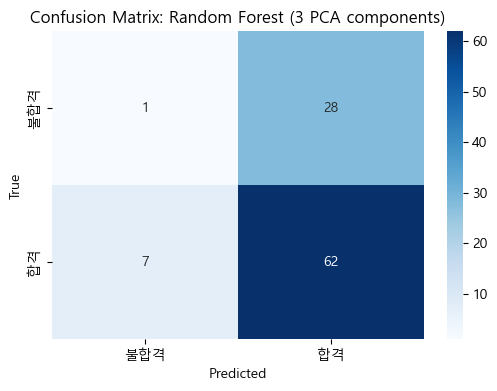

Model: SVM with 3 PCA components
Accuracy: 0.7041
Precision (Weighted Avg): 0.4957
Recall (Weighted Avg): 0.7041
F1-Score (Weighted Avg): 0.5818


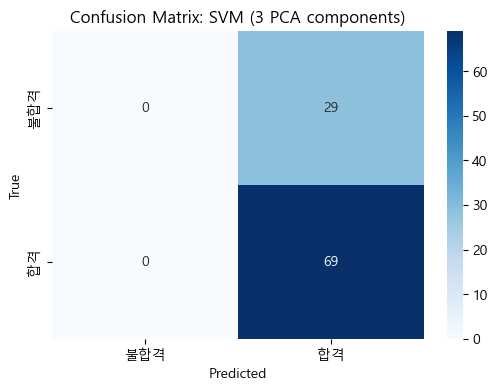

Model: Gradient Boosting with 3 PCA components
Accuracy: 0.6429
Precision (Weighted Avg): 0.5472
Recall (Weighted Avg): 0.6429
F1-Score (Weighted Avg): 0.5775


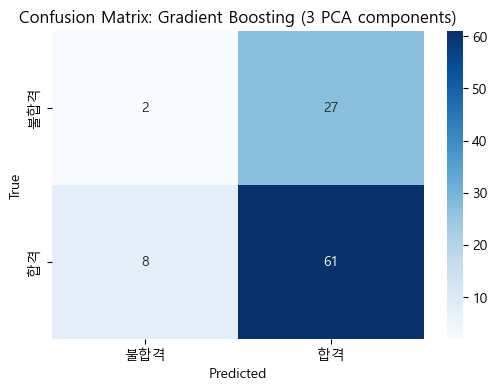

Model: k-NN with 3 PCA components
Accuracy: 0.6837
Precision (Weighted Avg): 0.6116
Recall (Weighted Avg): 0.6837
F1-Score (Weighted Avg): 0.6148


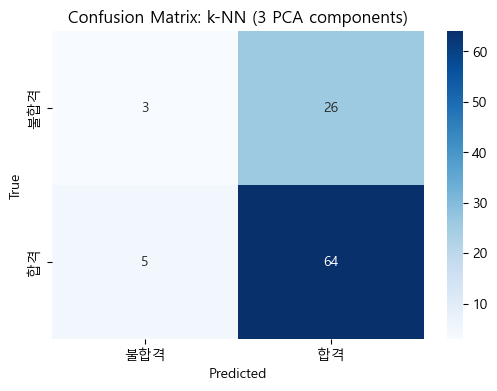

Model: Decision Tree with 3 PCA components
Accuracy: 0.6020
Precision (Weighted Avg): 0.6060
Recall (Weighted Avg): 0.6020
F1-Score (Weighted Avg): 0.6040


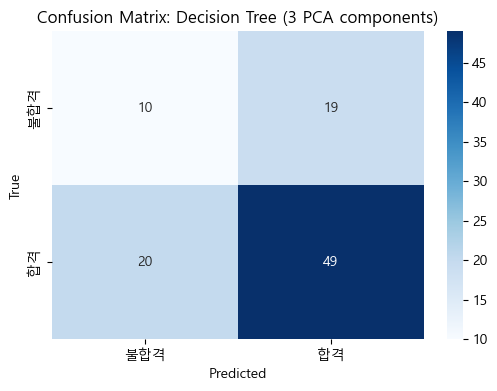

Model: XGBoost with 3 PCA components
Accuracy: 0.6224
Precision (Weighted Avg): 0.5634
Recall (Weighted Avg): 0.6224
F1-Score (Weighted Avg): 0.5842


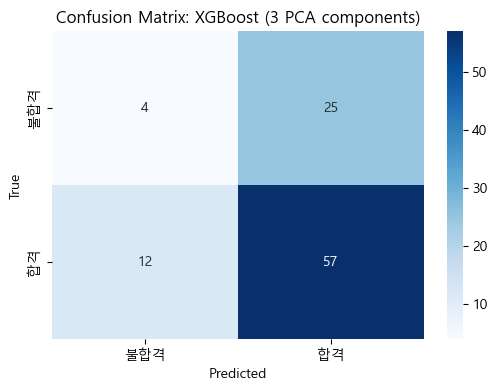

Model: Extra Trees with 3 PCA components
Accuracy: 0.6327
Precision (Weighted Avg): 0.5155
Recall (Weighted Avg): 0.6327
F1-Score (Weighted Avg): 0.5592


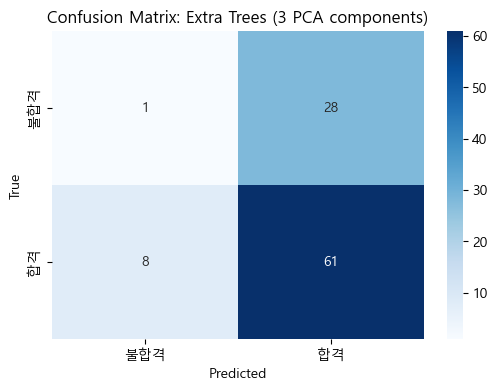

Model: MLP with 3 PCA components
Accuracy: 0.7245
Precision (Weighted Avg): 0.7313
Recall (Weighted Avg): 0.7245
F1-Score (Weighted Avg): 0.6413


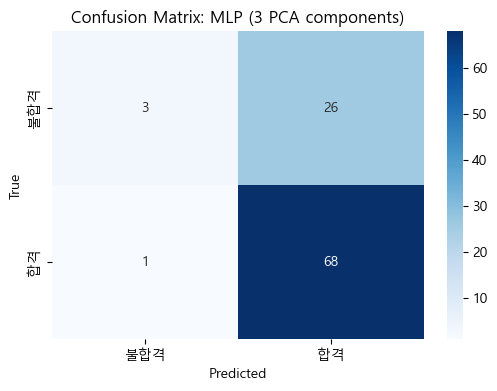


=== PCA with 1 components ===
Explained Variance Ratio: [0.27269924]


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.704082,0.495731,0.704082,0.581816
Random Forest,0.673469,0.597034,0.673469,0.608207
SVM,0.704082,0.495731,0.704082,0.581816
Gradient Boosting,0.653061,0.556243,0.653061,0.583720
k-NN,0.663265,0.598046,0.663265,0.611921
Decision Tree,0.510204,0.537026,0.510204,0.522032
XGBoost,0.622449,0.563402,0.622449,0.584166
Extra Trees,0.663265,0.598046,0.663265,0.611921
MLP,0.714286,0.701253,0.714286,0.620862



=== PCA with 2 components ===
Explained Variance Ratio: [0.27269924 0.15615531]


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.704082,0.495731,0.704082,0.581816
Random Forest,0.653061,0.556243,0.653061,0.583720
SVM,0.704082,0.495731,0.704082,0.581816
Gradient Boosting,0.632653,0.539377,0.632653,0.571193
k-NN,0.663265,0.598046,0.663265,0.611921
Decision Tree,0.591837,0.583512,0.591837,0.587464
XGBoost,0.632653,0.592544,0.632653,0.606798
Extra Trees,0.642857,0.565199,0.642857,0.588401
MLP,0.724490,0.801977,0.724490,0.627051



=== PCA with 3 components ===
Explained Variance Ratio: [0.27269924 0.15615531 0.09901523]


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.704082,0.495731,0.704082,0.581816
Random Forest,0.642857,0.522024,0.642857,0.565091
SVM,0.704082,0.495731,0.704082,0.581816
Gradient Boosting,0.642857,0.547240,0.642857,0.577471
k-NN,0.683673,0.611650,0.683673,0.614795
Decision Tree,0.602041,0.605992,0.602041,0.603961
XGBoost,0.622449,0.563402,0.622449,0.584166
Extra Trees,0.632653,0.515453,0.632653,0.559233
MLP,0.724490,0.731274,0.724490,0.641258


In [17]:
# 입력 변수 (검사항목 1~27)
all_features = [str(i) for i in range(1, 28)]
fixed_features = ["5", "6", "8", "14", "22", "22", "24", "26", "27"] # PCA 제외 열 설정
pca_features = [col for col in all_features if col not in fixed_features]

# 독립변수 및 종속변수 설정
X_fixed = qim_final_df[fixed_features]
X_pca_input = qim_final_df[pca_features]
y = qim_final_df['합격여부']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/Test Split
X_fixed_train, X_fixed_test, X_pca_train, X_pca_test, y_train, y_test = train_test_split(
    X_fixed, X_pca_input, y_encoded, test_size=0.2, random_state=42
)

# MinMaxScaler 적용
scaler_fixed = MinMaxScaler()
X_fixed_train_scaled = scaler_fixed.fit_transform(X_fixed_train)
X_fixed_test_scaled = scaler_fixed.transform(X_fixed_test)

scaler_pca = MinMaxScaler()
X_pca_train_scaled = scaler_pca.fit_transform(X_pca_train)
X_pca_test_scaled = scaler_pca.transform(X_pca_test)

# PCA 변수 1개, 2개, 3개 생성 후 분류 수행 및 결과 비교
results_all = {}
for n_components in [1, 2, 3]:
    print(f"\n=== PCA with {n_components} components ===")
    results, explained_var_ratio = classify_with_pca(n_components)
    results_all[n_components] = {
        "results": results,
        "explained_variance_ratio": explained_var_ratio
    }

# 결과 데이터프레임 출력
for n_components in results_all.keys():
    print(f"\n=== PCA with {n_components} components ===")
    explained_var_ratio = results_all[n_components]['explained_variance_ratio']
    print(f"Explained Variance Ratio: {explained_var_ratio}")
    results_df = pd.DataFrame(results_all[n_components]['results']).T
    display(results_df)

## 7. 이상탐지

Running Isolation Forest...
Model: Isolation Forest
Accuracy: 0.2986
Precision (Weighted Avg): 0.5317
Recall (Weighted Avg): 0.2986
F1-Score (Weighted Avg): 0.2206


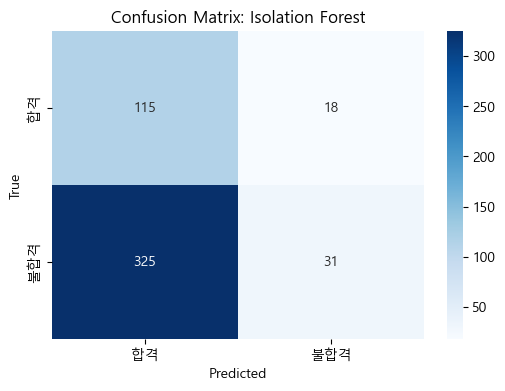

Running One-Class SVM...
Model: One-Class SVM
Accuracy: 0.3088
Precision (Weighted Avg): 0.5675
Recall (Weighted Avg): 0.3088
F1-Score (Weighted Avg): 0.2332


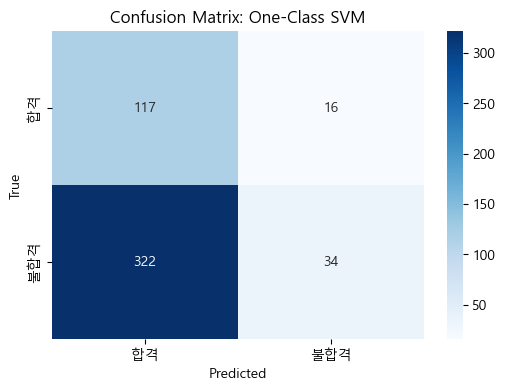

Running DBSCAN...
Model: DBSCAN
Accuracy: 0.7280
Precision (Weighted Avg): 0.5300
Recall (Weighted Avg): 0.7280
F1-Score (Weighted Avg): 0.6134


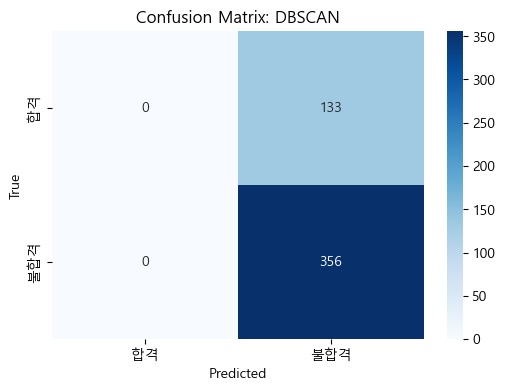

                  Accuracy  Precision    Recall  F1-Score
Isolation Forest  0.298569   0.531668  0.298569  0.220623
One-Class SVM     0.308793   0.567539  0.308793  0.233200
DBSCAN            0.728016   0.530008  0.728016  0.613429


In [18]:
# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(qim_final_df[[str(i) for i in range(1, 28)]])

true_labels = (qim_final_df['합격여부'] == '합격').astype(int)

# 이상 탐지 모델 정의
anomaly_models = {
    "Isolation Forest": IsolationForest(random_state=42, contamination=0.1),
    "One-Class SVM": OneClassSVM(kernel="rbf", nu=0.1),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
}

# 이상 탐지 수행 및 평가
results = {}
for name, model in anomaly_models.items():
    print(f"Running {name}...")
    if name == "DBSCAN":
        pred_labels = (model.fit_predict(X_scaled) == -1).astype(int)
    else:
        pred_labels = (model.fit_predict(X_scaled) == -1).astype(int)
    accuracy = accuracy_score(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, output_dict=True)
    weighted_avg = report['weighted avg']
    results[name] = {
        "Accuracy": accuracy,
        "Precision": weighted_avg['precision'],
        "Recall": weighted_avg['recall'],
        "F1-Score": weighted_avg['f1-score']
    }
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted Avg): {weighted_avg['precision']:.4f}")
    print(f"Recall (Weighted Avg): {weighted_avg['recall']:.4f}")
    print(f"F1-Score (Weighted Avg): {weighted_avg['f1-score']:.4f}")
    print("=" * 50)
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["합격", "불합격"], yticklabels=["합격", "불합격"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 결과 데이터프레임으로 변환
results_df = pd.DataFrame(results).T
print(results_df)


### LoF 모델 적용

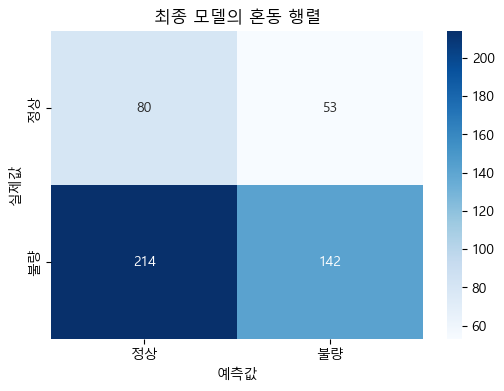

Model Performance Metrics
Accuracy: 0.4540
Precision (Weighted Avg): 0.6042
Recall (Weighted Avg): 0.4540
F1-Score (Weighted Avg): 0.4772


In [19]:
# '일련번호'를 제외하고 정규화 수행
columns_to_scale = [col for col in qim_final_df.columns if col not in ['일련번호', '합격여부']]
X = qim_final_df[columns_to_scale]  
y = (qim_final_df['합격여부'] == '합격').astype(int)  

kf = KFold(n_splits=5, shuffle=True, random_state=42)

Stacked_Train_List = []
Stacked_Test_List = []

# KFold를 사용한 학습 및 테스트 데이터 분리
for train_index, test_index in kf.split(X):
    train_data, test_data = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # MinMax 정규화
    scaler = MinMaxScaler()
    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)
    
    train_list = []
    test_list = []
    for i in range(100):  # contamination 수준을 0.005부터 0.5까지 반복
        contamination_level = (i + 1) / 200 
        model_LOF = LocalOutlierFactor(n_neighbors=20, contamination=contamination_level, novelty=True)
        model_LOF.fit(train_data_scaled)
        
        train_scores = pd.DataFrame(model_LOF.decision_function(test_data_scaled), columns=[str(contamination_level)], index=test_data.index)
        train_list.append(train_scores)
        
        test_scores = pd.DataFrame(model_LOF.decision_function(test_data_scaled), columns=[str(contamination_level)], index=test_data.index)
        test_list.append(test_scores)
    
    Stacked_Train_List.append(pd.concat(train_list, axis=1))
    Stacked_Test_List.append(pd.concat(test_list, axis=1))

# 모든 fold의 결과를 결합
Stacking_Data = pd.concat(Stacked_Train_List, axis=0)
Abnormal_Data = pd.concat(Stacked_Test_List, axis=0)

# 평균 점수 계산
Abnormal_Data = Abnormal_Data.groupby(Abnormal_Data.index).mean()

scaler2 = MinMaxScaler()
scaler2.fit(Stacking_Data)
Scaled_Stacked_Train_Data = pd.DataFrame(scaler2.transform(Stacking_Data), index=Stacking_Data.index)
Scaled_Stacked_Test_Data = pd.DataFrame(scaler2.transform(Abnormal_Data), index=Abnormal_Data.index)

# LOF 모델 훈련
Con = 0.42  # contamination 수준 설정
model_LOF = LocalOutlierFactor(n_neighbors=35, contamination=Con, novelty=True)
model_LOF.fit(Scaled_Stacked_Train_Data)

# 예측 결과 및 평가
final_result = pd.DataFrame(model_LOF.predict(Scaled_Stacked_Test_Data), index=Scaled_Stacked_Test_Data.index, columns=['prediction'])
final_result['prediction'] = final_result['prediction'].map({1: 0, -1: 1})  # LOF 예측을 0(정상), 1(불량)으로 변환

# 혼동 행렬 생성
cm = confusion_matrix(y.loc[final_result.index], final_result['prediction'])
report = classification_report(y.loc[final_result.index], final_result['prediction'], target_names=['정상', '불량'], output_dict=True)

accuracy = report['accuracy']
precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_score_weighted = report['weighted avg']['f1-score']

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['정상', '불량'], yticklabels=['정상', '불량'])
plt.title("최종 모델의 혼동 행렬")
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.show()

# 성능 지표
print(f"Model Performance Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted Avg): {precision_weighted:.4f}")
print(f"Recall (Weighted Avg): {recall_weighted:.4f}")
print(f"F1-Score (Weighted Avg): {f1_score_weighted:.4f}")
print("=" * 50)


## 8. 검사항목 9번의 측정값 예측 (회귀모델)

### 데이터프레임 생성

In [20]:
# 정의된 함수를 사용하여 데이터 재구성 
total_df = merge_with_selected_columns(qim_final_df, asrp_combined_sorted)

# 학습에 사용되지 않는 '합격여부' 열 제거
if '합격여부' in total_df.columns:
    pass_fail_col = total_df.pop('합격여부')  

# QIM 열들을 정렬: '일련번호', '운용월' 제외 및 '_측정치'로 끝나지 않는 열을 숫자로 정렬
qim_columns = sorted([col for col in total_df.columns if col not in ['일련번호', '운용월'] and not col.endswith('_측정치')], key=lambda x: int(x))

# 측정치 열들을 정렬: '_측정치'로 끝나는 열을 숫자로 정렬
measurement_columns = sorted([col for col in total_df.columns if col.endswith('_측정치')], key=lambda x: int(x.split('_')[0]))


# 모든 행을 복사하여 두 번씩 반복 (첫 행은 QIM 시점, 두 번째 행은 표본검사 시점)
total_df = pd.concat([total_df] * 2).sort_index().reset_index(drop=True)

# 홀수 행의 '누적운용일' 값을 0으로 설정 (QIM 데이터의 누적운용일은 0)
for i in range(0, len(total_df), 2):
    total_df.at[i, '운용월'] = 0 # QIM 시점의'운용월' 값을 0으로 설정
    
    for col in measurement_columns: # 모든 측정치 열에 대해 반복
        if pd.notna(total_df.at[i, col]): # 짝수 행의 측정치 값이 NaN이 아닌 경우
            qim_column = col.split('_')[0] # 측정치 열 이름에서 QIM 열 이름 추출
            total_df.at[i, col] = total_df.at[i, qim_column] # QIM 값을 측정치 값으로 대체

In [21]:
# 생성된 데이터프레임 확인인
total_df

,일련번호,1,2,3,4,5,6,7,8,9,...,19_측정치,20_측정치,21_측정치,22_측정치,23_측정치,24_측정치,25_측정치,26_측정치,27_측정치,운용월
0,SG 14 C517 00,2.28,2.16,1800,550,530,2300,5200,540,2.87,...,14.98,-14.87,NaN,NaN,20.7,0.73,NaN,NaN,NaN,0.0
1,SG 14 C517 00,2.28,2.16,1800,550,530,2300,5200,540,2.87,...,15.015,-15.234,NaN,NaN,2.781,-0.9,NaN,NaN,NaN,154.0
2,SG 15 D004 00,2.2,2,1800,600,550,2300,5400,560,2.87,...,14.98,-15.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,SG 15 D004 00,2.2,2,1800,600,550,2300,5400,560,2.87,...,15.033,-14.758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0
4,SG 15 C927 00,2.12,2,1800,560,550,2400,5500,560,2.87,...,14.96,-14.89,9.89,0.11,20.93,0.59,9.86,0.15,24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,SG 16 D075K 00,2.17,2.05,2100,580,550,3000,6100,570,2.23,...,15,-15.25,2.53,-4.38,-26.31,-1.47,-25.04,-1.7,3.4,101.0
974,SG 17 D364K 00,2.2,2.07,2200,590,550,3100,5800,570,2.23,...,15.01,-14.94,9.82,0.25,21.56,1.28,9.85,0.31,24,0.0
975,SG 17 D364K 00,2.2,2.07,2200,590,550,3100,5800,570,2.23,...,15.01,-15.23,-0.98,-1.91,-26.29,1.38,-25.05,0.75,4.6,101.0
976,SG 18 D602K 00,2.18,2.03,2100,590,550,3100,6000,580,2.23,...,15,-14.89,9.98,0.3,21.7,1.12,10.06,0.37,24,0.0


In [22]:
# 일련번호 고유값 추출
serial_numbers = total_df['일련번호'].unique()

# 일련번호들을 8:2 비율로 train/test 분리
train_serials, test_serials = train_test_split(serial_numbers, test_size=0.2, random_state=42)

# 일련번호에 해당하는 데이터만 분리
train_df = total_df[total_df['일련번호'].isin(train_serials)]
test_df = total_df[total_df['일련번호'].isin(test_serials)]

# '누적운용일' 열의 값이 0인 행 제거
test_df = total_df[total_df['운용월'] != 0]

### 모델 적용

In [23]:
# 사용할 독립변수 선정
x_columns =['운용월','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26', '27'] 

# 예측할 종속변수 선정
y_columns =['9_측정치'] 

x_train = train_df[x_columns]
y_train = train_df[y_columns]
x_test = test_df[x_columns]
y_test = test_df[y_columns]

# MinMax 정규화 정의
scaler = MinMaxScaler()

# 정규화 적용
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [24]:
# 모델 정의
models = {
    'SVR': SVR(),
    'XGBoost': XGBRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor()
}

# 성능을 저장할 리스트
performances = []

# 모델 학습 및 평가
for model_name, model in models.items():
    model.fit(x_train_scaled, y_train.values.ravel()) 
    
    y_pred = model.predict(x_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    pocid = calculate_pocid(y_test.values.ravel(), y_pred)

    performances.append((model_name, rmse, mape, pocid))
    print(f"{model_name}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}, POCID = {pocid:.2f}%")

# 최종 성능 출력
print("\n모델 성능 비교:")
for model_name, rmse, mape, pocid in performances:
    print(f"{model_name}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}, POCID = {pocid:.2f}%")

SVR: RMSE = 0.1356, MAPE = 0.0269, POCID = 15.16%
XGBoost: RMSE = 0.0307, MAPE = 0.0025, POCID = 19.88%
Random Forest: RMSE = 0.0447, MAPE = 0.0056, POCID = 28.89%
Gradient Boosting: RMSE = 0.0384, MAPE = 0.0065, POCID = 14.34%
KNN: RMSE = 0.1669, MAPE = 0.0251, POCID = 15.98%

모델 성능 비교:
SVR: RMSE = 0.1356, MAPE = 0.0269, POCID = 15.16%
XGBoost: RMSE = 0.0307, MAPE = 0.0025, POCID = 19.88%
Random Forest: RMSE = 0.0447, MAPE = 0.0056, POCID = 28.89%
Gradient Boosting: RMSE = 0.0384, MAPE = 0.0065, POCID = 14.34%
KNN: RMSE = 0.1669, MAPE = 0.0251, POCID = 15.98%


In [25]:
# PCA 적용에서 제외할 열(유의하다고 판단되는 변수)
excluded_columns = ['5', '6', '8', '14', '22', '24', '26', '27']

# PCA 적용할 열 ()
pca_columns = ['1', '2', '3', '4', '7', '9', '10', 
                  '11', '12', '13', '15', '16', '17', '18', '19', 
                  '20', '21', '23', '25']

# '운용월'을 필수 변수로 지정
mandatory_column = '운용월'

# 모델 정의
models = {
    'SVR': SVR(),
    'XGBoost': XGBRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor()
}

# 성능 저장 및 최적 조합 탐색
best_performances = {
    model_name: {'rmse': {'combo': None, 'value': float('inf')},
                 'mape': {'combo': None, 'value': float('inf')},
                 'pocid': {'combo': None, 'value': 0}}
    for model_name in models.keys()
}

pca = PCA(n_components=2)

y_columns = ['9_측정치']

pca_train = pca.fit_transform(train_df[pca_columns])
pca_test = pca.transform(test_df[pca_columns])

train_df_pca = train_df[excluded_columns].copy()
train_df_pca['PCA1'] = pca_train[:, 0]
train_df_pca['PCA2'] = pca_train[:, 1]

test_df_pca = test_df[excluded_columns].copy()
test_df_pca['PCA1'] = pca_test[:, 0]
test_df_pca['PCA2'] = pca_test[:, 1]

if mandatory_column not in train_df_pca.columns:
    train_df_pca[mandatory_column] = train_df[mandatory_column]
    test_df_pca[mandatory_column] = test_df[mandatory_column]

# 입력 변수 조합 생성 및 모델 평가
for x_length in range(1, 11):  
    for x_combo in combinations([col for col in train_df_pca.columns if col != mandatory_column], x_length):
        # '운용월' 추가
        x_combo = list(x_combo) + [mandatory_column]

        x_train = train_df_pca[x_combo]
        y_train = train_df[y_columns]
        x_test = test_df_pca[x_combo]
        y_test = test_df[y_columns]

        if len(x_train) != len(y_train) or len(x_test) != len(y_test):
            continue

        # MinMax 정규화
        scaler = MinMaxScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # 각 모델에 대해 학습 및 평가
        for model_name, model in models.items():
            try:
                model.fit(x_train_scaled, y_train.values.ravel()) 
                
                y_pred = model.predict(x_test_scaled)
                
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mape = mean_absolute_percentage_error(y_test, y_pred)
                pocid = calculate_pocid(y_test.values.ravel(), y_pred)
                
                if rmse < best_performances[model_name]['rmse']['value']:
                    best_performances[model_name]['rmse'] = {'combo': x_combo, 'value': rmse}
                if mape < best_performances[model_name]['mape']['value']:
                    best_performances[model_name]['mape'] = {'combo': x_combo, 'value': mape}
                if pocid > best_performances[model_name]['pocid']['value']:
                    best_performances[model_name]['pocid'] = {'combo': x_combo, 'value': pocid}
            except ValueError:
                continue

# 최적 조합 결과 출력
print("\n모델별 최적 성능 조합:")
for model_name, metrics in best_performances.items():
    print(f"\n{model_name}:")
    print(f"  RMSE 최적 조합: {metrics['rmse']['combo']} - 값: {metrics['rmse']['value']:.4f}")
    print(f"  MAPE 최적 조합: {metrics['mape']['combo']} - 값: {metrics['mape']['value']:.4f}")
    print(f"  POCID 최적 조합: {metrics['pocid']['combo']} - 값: {metrics['pocid']['value']:.2f}%")


모델별 최적 성능 조합:

SVR:
  RMSE 최적 조합: ['5', '6', '8', '14', '22', '24', '26', 'PCA1', '운용월'] - 값: 0.2107
  MAPE 최적 조합: ['5', '6', '8', '14', '22', '24', '26', 'PCA2', '운용월'] - 값: 0.0334
  POCID 최적 조합: ['27', '운용월'] - 값: 17.42%

XGBoost:
  RMSE 최적 조합: ['14', '22', '24', 'PCA2', '운용월'] - 값: 0.1003
  MAPE 최적 조합: ['14', '22', '24', 'PCA2', '운용월'] - 값: 0.0077
  POCID 최적 조합: ['6', '8', '22', '24', '26', '27', 'PCA2', '운용월'] - 값: 18.85%

Random Forest:
  RMSE 최적 조합: ['6', '22', 'PCA2', '운용월'] - 값: 0.1243
  MAPE 최적 조합: ['24', '26', 'PCA1', 'PCA2', '운용월'] - 값: 0.0180
  POCID 최적 조합: ['6', '27', '운용월'] - 값: 18.44%

Gradient Boosting:
  RMSE 최적 조합: ['6', '14', '24', '26', '27', 'PCA1', 'PCA2', '운용월'] - 값: 0.1607
  MAPE 최적 조합: ['5', '8', '14', '22', '24', '26', 'PCA1', 'PCA2', '운용월'] - 값: 0.0254
  POCID 최적 조합: ['27', '운용월'] - 값: 19.06%

KNN:
  RMSE 최적 조합: ['6', '24', '26', 'PCA1', '운용월'] - 값: 0.1935
  MAPE 최적 조합: ['6', '8', '27', 'PCA2', '운용월'] - 값: 0.0313
  POCID 최적 조합: ['6', '운용월'] - 값: 17.62%
